In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
from operator import itemgetter
from collections import Counter

from pylab import rcParams

plt.style.use('ggplot')
rcParams['figure.figsize'] = 10, 8
sns.set(font_scale=1) 
cmap = sns.diverging_palette(220, 10, as_cmap=True)


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Data Analysis

In [8]:
data = pd.read_csv("My Uber Drives - 2016.csv")
data = data[:-1]
data.head(5)


,START_DATE*,END_DATE*,CATEGORY*,START*,STOP*,MILES*,PURPOSE*
0,1/1/2016 21:11,1/1/2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,1/2/2016 1:25,1/2/2016 1:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,1/2/2016 20:25,1/2/2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,1/5/2016 17:31,1/5/2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,1/6/2016 14:42,1/6/2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [9]:
data.describe(include=['O']).transpose()

,count,unique,top,freq
START_DATE*,1155,1154,6/28/2016 23:34,2
END_DATE*,1155,1154,6/28/2016 23:59,2
CATEGORY*,1155,2,Business,1078
START*,1155,177,Cary,201
STOP*,1155,188,Cary,203
PURPOSE*,653,10,Meeting,187


In [10]:
data.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 7 columns):
START_DATE*    1155 non-null object
END_DATE*      1155 non-null object
CATEGORY*      1155 non-null object
START*         1155 non-null object
STOP*          1155 non-null object
MILES*         1155 non-null float64
PURPOSE*       653 non-null object
dtypes: float64(1), object(6)
memory usage: 63.2+ KB


In [11]:
data.isnull().any()


START_DATE*    False
END_DATE*      False
CATEGORY*      False
START*         False
STOP*          False
MILES*         False
PURPOSE*        True
dtype: bool

In [12]:
data = data.rename(columns = {'START_DATE*': 'StartDate', 'END_DATE*': 'EndDate', 'CATEGORY*': 'Category', 'START*': 'Start', 'STOP*': 'Stop', 'MILES*': 'Miles', 'PURPOSE*': 'Purpose'})

In [13]:
data['Purpose'].replace(np.nan, 'Other', inplace=True)


## Number of Rides Based on Type of Purpose

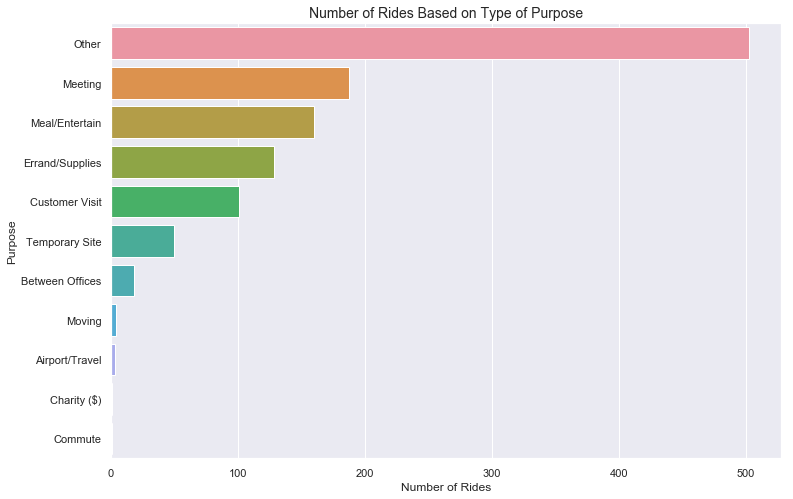

In [14]:
rcParams['figure.figsize'] = 12, 8
data_grouped = data.groupby('Purpose').size().reset_index(name="Frequency")
ax = sns.barplot(x='Frequency',y='Purpose', data=data_grouped.sort_values(by='Frequency', ascending=0))
ax.set(xlabel='Number of Rides', ylabel='Purpose')
plt.title("Number of Rides Based on Type of Purpose", fontsize='14')
plt.show()

In [15]:
print(data.groupby('Purpose').size().sort_values(ascending=False), '\n')


Purpose
Other              502
Meeting            187
Meal/Entertain     160
Errand/Supplies    128
Customer Visit     101
Temporary Site      50
Between Offices     18
Moving               4
Airport/Travel       3
Commute              1
Charity ($)          1
dtype: int64 



## Percentage of Rides Based on Type of Category Type

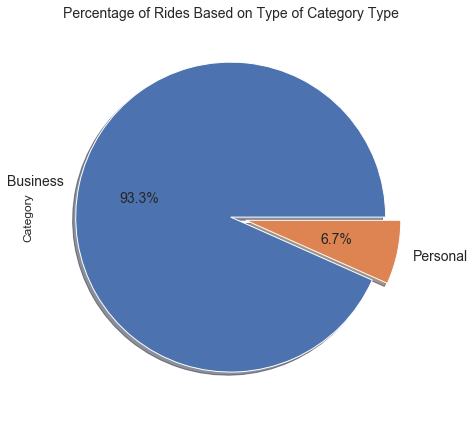

In [16]:
data['Category'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%',shadow=True, figsize=(8,6), fontsize=14)
plt.title("Percentage of Rides Based on Type of Category Type", fontsize=14)
plt.tight_layout()
plt.show()

In [17]:
print(data.groupby('Category').size().sort_values(ascending=False), '\n')

Category
Business    1078
Personal      77
dtype: int64 



## Ride Summary - Miles Based on Purpose

In [18]:
data_grouped = data.groupby(['Purpose'])['Miles'].mean().reset_index()
data_grouped.set_index('Purpose', inplace=True)
data_grouped.reset_index(inplace= True)

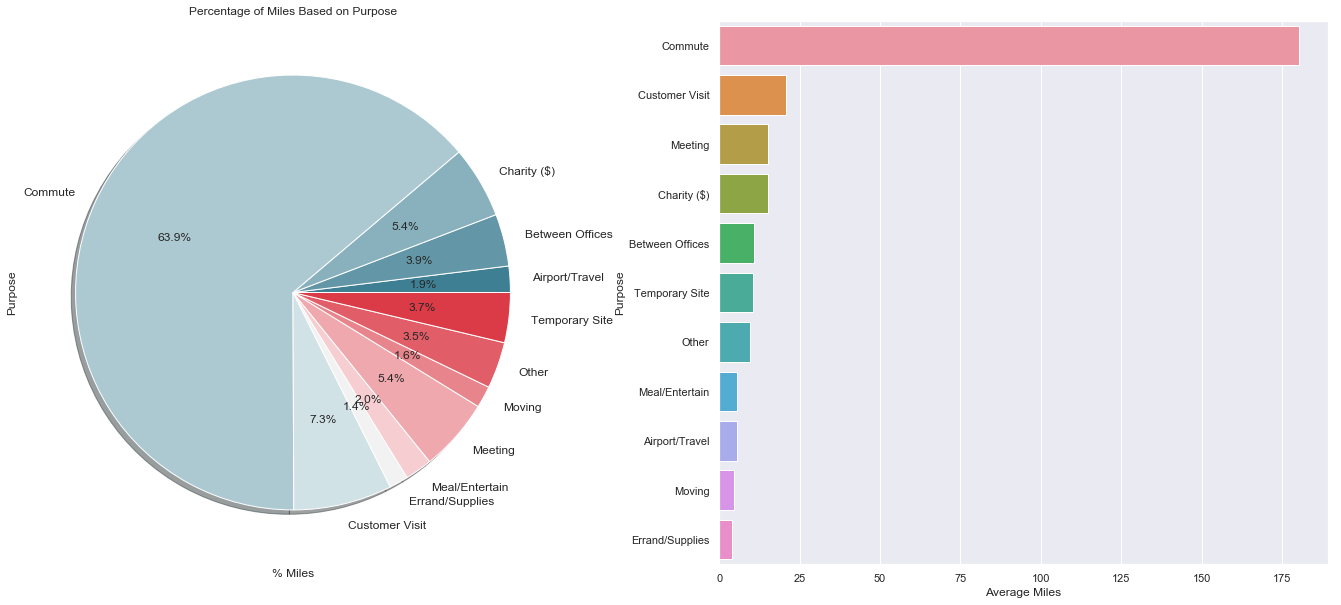

In [19]:
f, ax = plt.subplots(1, 2, figsize=(24,10))
data_grouped.set_index('Purpose')['Miles'].plot.pie(autopct='%1.1f%%', ax=ax[0], cmap= cmap, shadow=True, fontsize=12, title='Percentage of Miles Based on Purpose')
ax[0].set(xlabel='% Miles', ylabel='Purpose')
sns.barplot(x='Miles',y='Purpose', data=data_grouped.sort_values(by='Miles', ascending=0),ax=ax[1])
ax[1].set(xlabel='Average Miles', ylabel='Purpose')
plt.show()

In [20]:
df = data.copy()

df['StartDate'] = pd.to_datetime(df['StartDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'])

df['StartTime'] = df['StartDate'].dt.time
df['StartDate'] =  pd.to_datetime(df['StartDate'].dt.date)
df['EndTime'] = df['EndDate'].dt.time
df['EndDate'] =  pd.to_datetime(df['EndDate'].dt.date)

df.tail(5)

,StartDate,EndDate,Category,Start,Stop,Miles,Purpose,StartTime,EndTime
1150,2016-12-31,2016-12-31,Business,Kar?chi,Kar?chi,0.7,Meeting,01:07:00,01:14:00
1151,2016-12-31,2016-12-31,Business,Kar?chi,Unknown Location,3.9,Temporary Site,13:24:00,13:42:00
1152,2016-12-31,2016-12-31,Business,Unknown Location,Unknown Location,16.2,Meeting,15:03:00,15:38:00
1153,2016-12-31,2016-12-31,Business,Katunayake,Gampaha,6.4,Temporary Site,21:32:00,21:50:00
1154,2016-12-31,2016-12-31,Business,Gampaha,Ilukwatta,48.2,Temporary Site,22:08:00,23:51:00


## Number of Rides Based on Months

In [21]:
df_per_month = df.groupby(df.StartDate.dt.month).size().reset_index(name="Count")
df_per_month.columns = ['Month', 'Count']

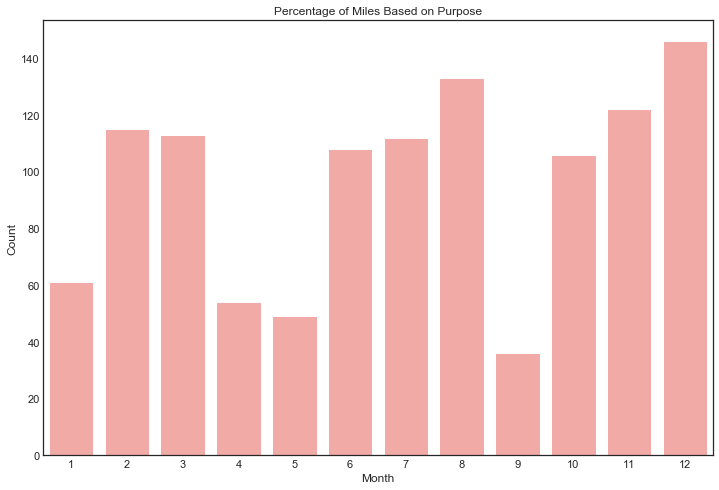

In [22]:
plt.style.use('seaborn-white')
rcParams['figure.figsize'] = 12, 8
ax = sns.barplot(x='Month',y='Count', data=df_per_month, color='#FF9F9A')
ax.set(title='Percentage of Miles Based on Purpose')
ax.set(xlabel='Month', ylabel='Count')
plt.show()

# Network Analysis

## Graph Creation

In [23]:
G = nx.Graph()
G = nx.from_pandas_edgelist(df, source='Start',target='Stop', 
                           edge_attr=['StartDate', 'StartTime','EndDate','EndTime','Category','Miles','Purpose'])
print(nx.info(G))
#FG = nx.from_pandas_edgelist(data, source='Start', target='Stop', edge_attr=True,)

Name: 
Type: Graph
Number of nodes: 209
Number of edges: 280
Average degree:   2.6794


The graph has 209 nodes and 280 edges so the size of the network is 209.

On average the degree is 2.67

In [24]:
print(list(G.nodes())[:20])


['Fort Pierce', 'West Palm Beach', 'Palm Beach', 'Cary', 'Morrisville', 'Jamaica', 'New York', 'Queens', 'Elmhurst', 'Midtown', 'East Harlem', 'NoMad', 'Flatiron District', 'Midtown East', 'Hudson Square', 'Lower Manhattan', "Hell's Kitchen", 'Queens County', 'Downtown', 'Gulfton']


In [25]:
print(list(G.edges())[:20])


[('Fort Pierce', 'Fort Pierce'), ('Fort Pierce', 'West Palm Beach'), ('West Palm Beach', 'West Palm Beach'), ('West Palm Beach', 'Palm Beach'), ('Cary', 'Cary'), ('Cary', 'Morrisville'), ('Cary', 'Durham'), ('Cary', 'Raleigh'), ('Cary', 'Apex'), ('Cary', 'Chapel Hill'), ('Cary', 'Latta'), ('Cary', 'Florence'), ('Cary', 'Holly Springs'), ('Cary', 'Boone'), ('Cary', 'Wake Forest'), ('Cary', 'Eagle Rock'), ('Cary', 'Winston Salem'), ('Cary', 'Mebane'), ('Cary', 'Unknown Location'), ('Cary', 'Wake Co.')]


## Components and Subgraphs


In [26]:
subgraphsLst = list(nx.connected_component_subgraphs(G))
len(subgraphsLst)

28

Uber Rides Network contains 209 nodes, but the network is split into over 28 component subgraphs. 

### Network Component Distribution


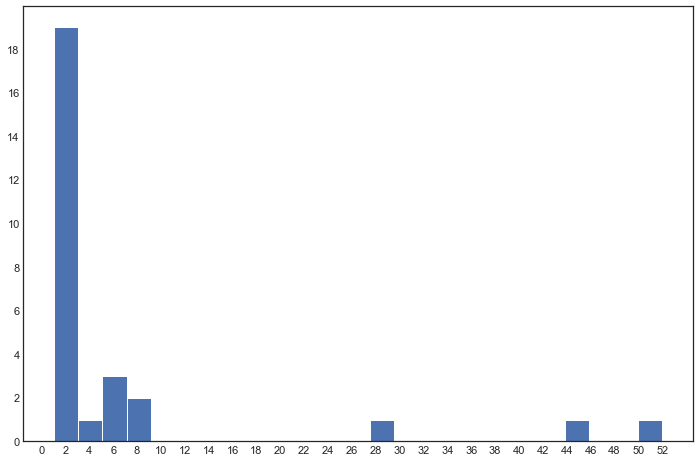

In [27]:
components =[len(c) for c in subgraphsLst]
plt.hist(components, bins = 25)
plt.xticks(range(0,54,2), rotation="horizontal")
plt.yticks(range(0,20,2), rotation="horizontal")
plt.show()

In [28]:
total_counts = [[x, components.count(x)] for x in set(components)]
comp_df = pd.DataFrame(total_counts, columns=['Component', 'Count'])
comp_df.set_index('Component', inplace=True)
comp_df.style.background_gradient(cmap=cmap)


,Count
Component,
1,3
2,8
3,8
5,1
6,1
7,2
8,1
9,1
44,1


Component subgraphs (or simply components) are portions of the network that are disconnected from each other. Of 28 components, 3 are of size 1 -these are called "isolates" and should be removed from the network-.There are 8 components of size 2 and 3. And the biggest subgraph is contains 52 nodes of a network.

# Visualization of Uber Traffic Flow Network

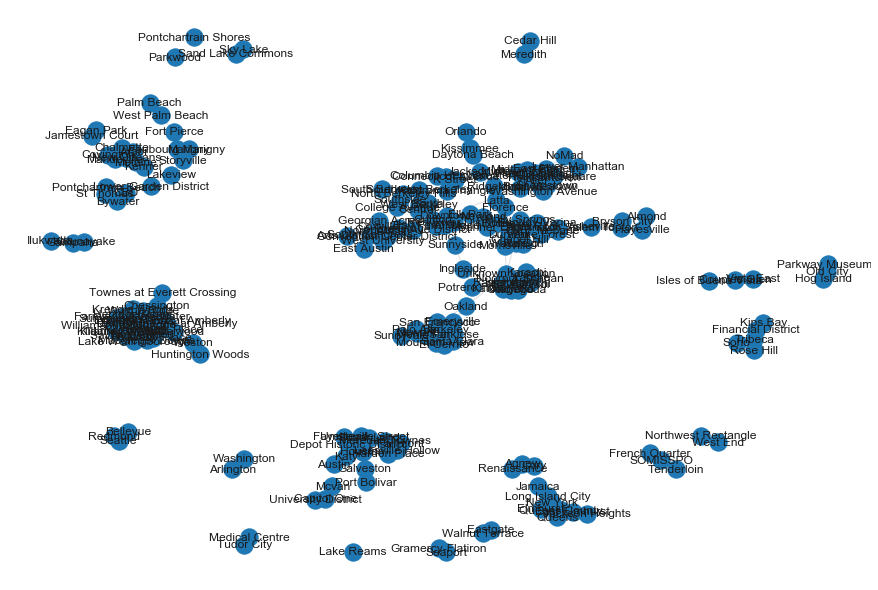

In [29]:
nx.draw_spring(G, edge_color='#dddddd', with_labels=True)
plt.show()

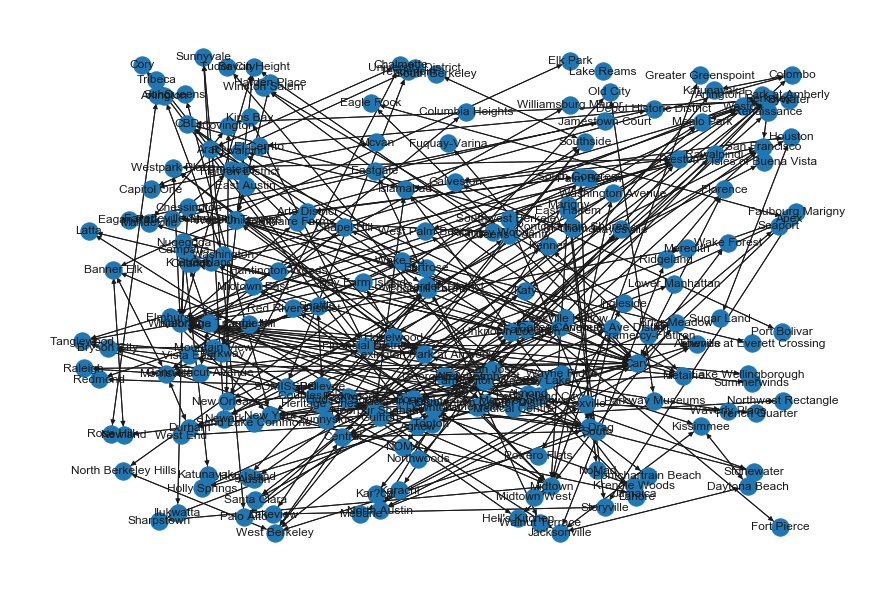

In [30]:
#nx.draw_spring(G, with_labels=True)
nx.draw_random(G.to_directed(), with_labels=True)
plt.show()

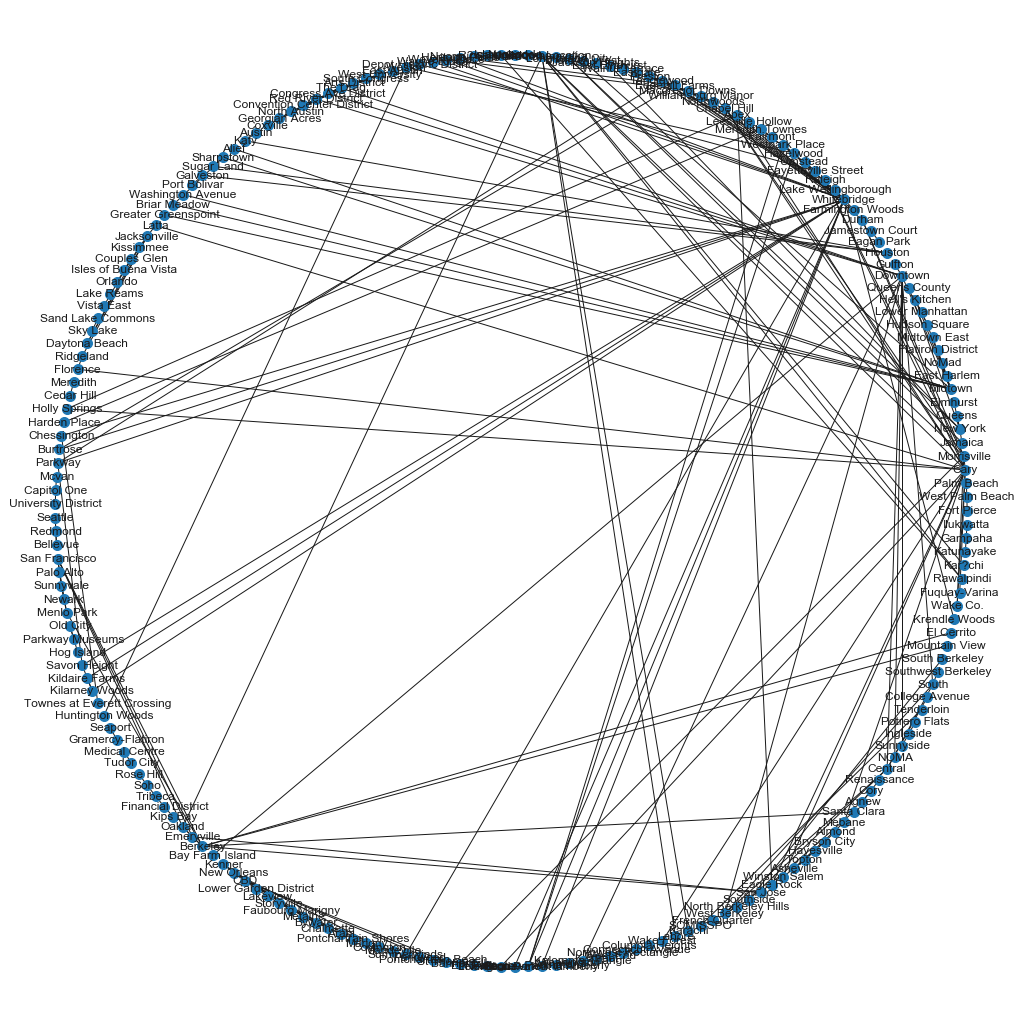

In [31]:
# Plot it
plt.figure(figsize=(14,14)) 
nx.draw_circular(G, with_labels=True,node_size=100)
plt.show()

## Analysis of Nodes

In [56]:
degree_dict = dict(G.degree(G.nodes()))
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by degree:")

degree_dist = pd.DataFrame(sorted_degree, columns=['Location','Degree'])
degree_dist.sort_values(by='Degree',ascending=False).head(20).style.background_gradient(cmap=cmap)

Top 20 nodes by degree:


,Location,Degree
0,Whitebridge,26
1,Cary,18
2,Unknown Location,15
3,Midtown,14
4,Downtown,12
5,Morrisville,9
6,Berkeley,8
8,Central,7
7,The Drag,7
9,New York,6


The results identifies which location is being visited more frequently. Here it can be seen that Whitebridge and Cary are the places taht are visited mostly.

### Distribution of the node degrees


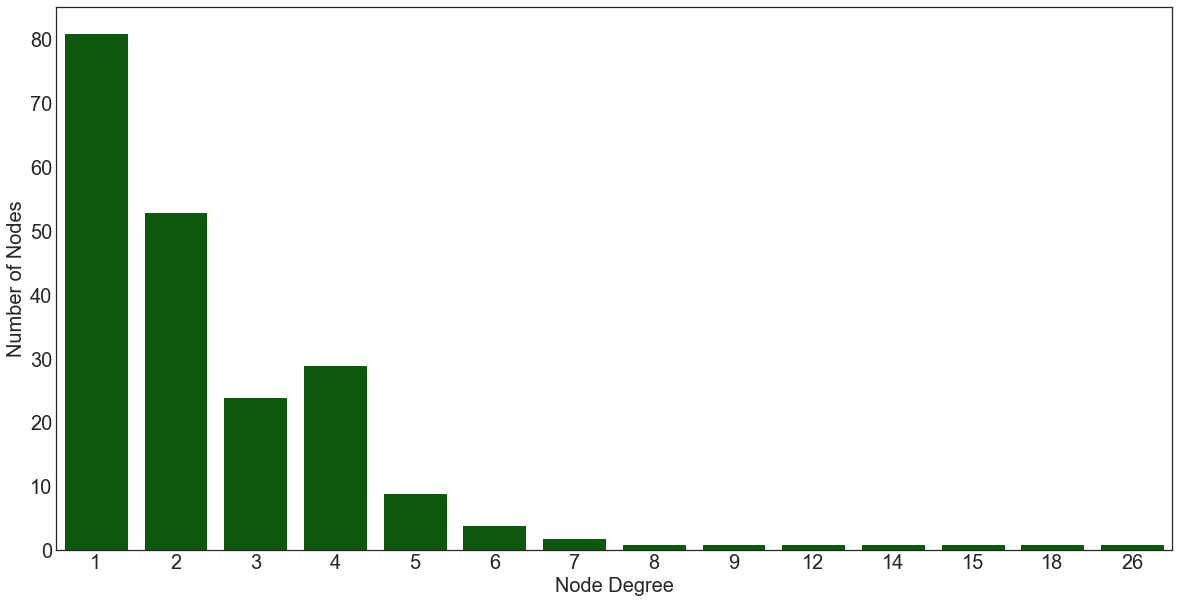

In [33]:
degree_dic = Counter(dict(G.degree()).values())
degree_hist = pd.DataFrame({"degree": list(degree_dic.values()),
                            "Number of Nodes": list(degree_dic.keys())})
plt.figure(figsize=(20,10))
sns.barplot(y = 'degree', x = 'Number of Nodes', data = degree_hist, color = 'darkgreen')
plt.xlabel('Node Degree', fontsize=20)
plt.ylabel('Number of Nodes', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

Most of the nodes tend to have a degree of 1 or 2 and 4.

### Network Density

In [34]:
density = nx.density(G)
print("Network density:", density)

Network density: 0.012881854987118146


The density of our network is approximately 0.0129. On a scale of 0 to 1, not a very dense network, which comports with what you can see in the visualization. A 0 would mean that there are no connections at all, and a 1 would indicate that all possible edges are present (a perfectly connected network): This Uber network is on the lower end of that scale, but still far from 0.

## Centrality

Centrality aims to find the most important nodes in a network. 

### Degree Centrality

In [35]:
degree_centrality = nx.algorithms.degree_centrality(G) 
sorted_degree_centrality = sorted(degree_centrality.items(), key=itemgetter(1), reverse=True)
sorted_degree_centrality[:10]

[('Whitebridge', 0.125),
 ('Cary', 0.08653846153846154),
 ('Unknown Location', 0.07211538461538462),
 ('Midtown', 0.06730769230769232),
 ('Downtown', 0.057692307692307696),
 ('Morrisville', 0.04326923076923077),
 ('Berkeley', 0.038461538461538464),
 ('The Drag', 0.03365384615384616),
 ('Central', 0.03365384615384616),
 ('New York', 0.028846153846153848)]

### Eigenvector Centrality

Eigenvector centrality is a kind of extension of degree—centrality. It looks at a combination of a node’s edges and the edges of that node’s neighbors. Eigenvector centrality cares if you are a hub, but it also cares how many hubs you are connected to. 

In [38]:
eigenvector_centrality = nx.algorithms.eigenvector_centrality(G, max_iter=500) # Notice the 3 airports from which all of our 100 rows of data originates
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=itemgetter(1), reverse=True)
sorted_eigenvector_centrality[:10]

[('Whitebridge', 0.6646598425612025),
 ('Preston', 0.2258961119723626),
 ('Lexington Park at Amberly', 0.20712910313780167),
 ('Edgehill Farms', 0.2051712166317349),
 ('Westpark Place', 0.20047189476573732),
 ('Tanglewood', 0.19234876125053213),
 ('Hazelwood', 0.17431819214287014),
 ('Northwoods', 0.17066934400969044),
 ('Parkway', 0.15923630129510694),
 ('Savon Height', 0.1533529382511316)]

### Katz Centrality

In [37]:
katz_centrality = nx.algorithms.katz_centrality(G, max_iter=500) # Notice the 3 airports from which all of our 100 rows of data originates
sorted_katz_centrality = sorted(katz_centrality.items(), key=itemgetter(1), reverse=True)
sorted_katz_centrality[:10]

[('Whitebridge', 0.2719384341254852),
 ('Cary', 0.1951184803643446),
 ('Unknown Location', 0.17465046022598132),
 ('Midtown', 0.13451560365297247),
 ('Downtown', 0.13322538808045487),
 ('Morrisville', 0.13251870013513256),
 ('Preston', 0.10870972414143357),
 ('Lexington Park at Amberly', 0.105085109926472),
 ('Edgehill Farms', 0.10424685821946111),
 ('Westpark Place', 0.10043500585941184)]

## Detecting Cliques

In [39]:
clique_lst = list(nx.find_cliques(G))
print(len(clique_lst))
clique_lst[:10]

173


[['Tenderloin', 'SOMISSPO'],
 ['Mountain View', 'Berkeley'],
 ['Lower Garden District', 'CBD'],
 ['Lower Garden District', 'Lakeview'],
 ['Fuquay-Varina', 'Cary'],
 ['Bellevue', 'Redmond', 'Seattle'],
 ['Rose Hill', 'Soho'],
 ['K Street', 'Kalorama Triangle'],
 ['Lakeview', 'Storyville'],
 ['St Thomas', 'CBD']]

A clique is defined as a maximal complete subgraph of a given graph.

## Density of Network

In [40]:
nx.density(G) # Average edge density of the Graphs

0.012881854987118146

Density measures how many links from all possible links within the network are realized.

## Average Degree Connectivity

In [57]:
#  # For a node of degree k - What is the average of its neighbours' degree?

average_degree_connectivity = dict(nx.average_degree_connectivity(G))
df_avg_degree_connectivity = pd.DataFrame(average_degree_connectivity, index=[0]).T
df_avg_degree_connectivity.columns = ['Avg Degree of Neighbors']
df_avg_degree_connectivity.style.background_gradient(cmap=cmap)

,Avg Degree of Neighbors
1,6.1358
2,6.56604
3,5.52778
4,4.65517
5,5.13333
6,3.91667
7,4.28571
8,2.875
9,6.55556
12,4.16667


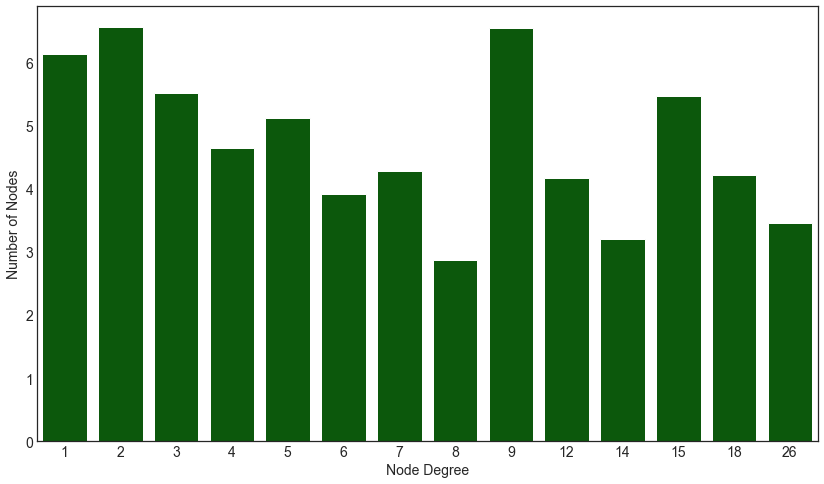

In [63]:
average_degree_connectivity_hist = pd.DataFrame({"degree": list(average_degree_connectivity.values()),
                            "Number of Nodes": list(degree_dic.keys())})
plt.figure(figsize=(14,8))
sns.barplot(y = 'degree', x = 'Number of Nodes', data = average_degree_connectivity_hist, color = 'darkgreen')
plt.xlabel('Node Degree', fontsize=14)
plt.ylabel('Number of Nodes', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

# Path Analysis 

### All available paths from San Francisco to Palo Alto

In [47]:
for path in nx.all_simple_paths(G, source='San Francisco', target='Palo Alto'):
    print(path)

['San Francisco', 'Palo Alto']
['San Francisco', 'Newark', 'Sunnyvale', 'Palo Alto']
['San Francisco', 'Newark', 'Menlo Park', 'Palo Alto']
['San Francisco', 'Emeryville', 'Oakland', 'Berkeley', 'Menlo Park', 'Newark', 'Sunnyvale', 'Palo Alto']
['San Francisco', 'Emeryville', 'Oakland', 'Berkeley', 'Menlo Park', 'Palo Alto']
['San Francisco', 'Emeryville', 'Berkeley', 'Menlo Park', 'Newark', 'Sunnyvale', 'Palo Alto']
['San Francisco', 'Emeryville', 'Berkeley', 'Menlo Park', 'Palo Alto']
['San Francisco', 'Emeryville', 'San Jose', 'Berkeley', 'Menlo Park', 'Newark', 'Sunnyvale', 'Palo Alto']
['San Francisco', 'Emeryville', 'San Jose', 'Berkeley', 'Menlo Park', 'Palo Alto']
['San Francisco', 'Emeryville', 'San Jose', 'Santa Clara', 'Berkeley', 'Menlo Park', 'Newark', 'Sunnyvale', 'Palo Alto']
['San Francisco', 'Emeryville', 'San Jose', 'Santa Clara', 'Berkeley', 'Menlo Park', 'Palo Alto']
['San Francisco', 'Oakland', 'Emeryville', 'Berkeley', 'Menlo Park', 'Newark', 'Sunnyvale', 'Palo Al

<img src="sanfrancisco_paloalto.png">

### All available paths from Oakland to Newark

In [48]:
# Let us find all the paths available
for path in nx.all_simple_paths(G, source='Oakland', target='Newark'):
    print(path)

['Oakland', 'Emeryville', 'Berkeley', 'San Francisco', 'Palo Alto', 'Sunnyvale', 'Newark']
['Oakland', 'Emeryville', 'Berkeley', 'San Francisco', 'Palo Alto', 'Menlo Park', 'Newark']
['Oakland', 'Emeryville', 'Berkeley', 'San Francisco', 'Newark']
['Oakland', 'Emeryville', 'Berkeley', 'Menlo Park', 'Newark']
['Oakland', 'Emeryville', 'Berkeley', 'Menlo Park', 'Palo Alto', 'San Francisco', 'Newark']
['Oakland', 'Emeryville', 'Berkeley', 'Menlo Park', 'Palo Alto', 'Sunnyvale', 'Newark']
['Oakland', 'Emeryville', 'San Francisco', 'Palo Alto', 'Sunnyvale', 'Newark']
['Oakland', 'Emeryville', 'San Francisco', 'Palo Alto', 'Menlo Park', 'Newark']
['Oakland', 'Emeryville', 'San Francisco', 'Newark']
['Oakland', 'Emeryville', 'San Francisco', 'Berkeley', 'Menlo Park', 'Newark']
['Oakland', 'Emeryville', 'San Francisco', 'Berkeley', 'Menlo Park', 'Palo Alto', 'Sunnyvale', 'Newark']
['Oakland', 'Emeryville', 'San Jose', 'Berkeley', 'San Francisco', 'Palo Alto', 'Sunnyvale', 'Newark']
['Oakland',

<img src="oakland_neward.PNG">

### Shortest path from Oakland to Newark

In [65]:
dijpath = nx.dijkstra_path(G, source='Oakland', target='Newark')
dijpath

['Oakland', 'San Francisco', 'Newark']

# Visalization of Network of Rides Based on Meeting Purpose

In [66]:
g_meeting = nx.Graph()
g_meeting = nx.from_pandas_edgelist(df[df['Purpose']=='Meeting'],source='Start',target='Stop')

The highest number of rides is for meeting purpose.

Name: 
Type: Graph
Number of nodes: 83
Number of edges: 71
Average degree:   1.7108


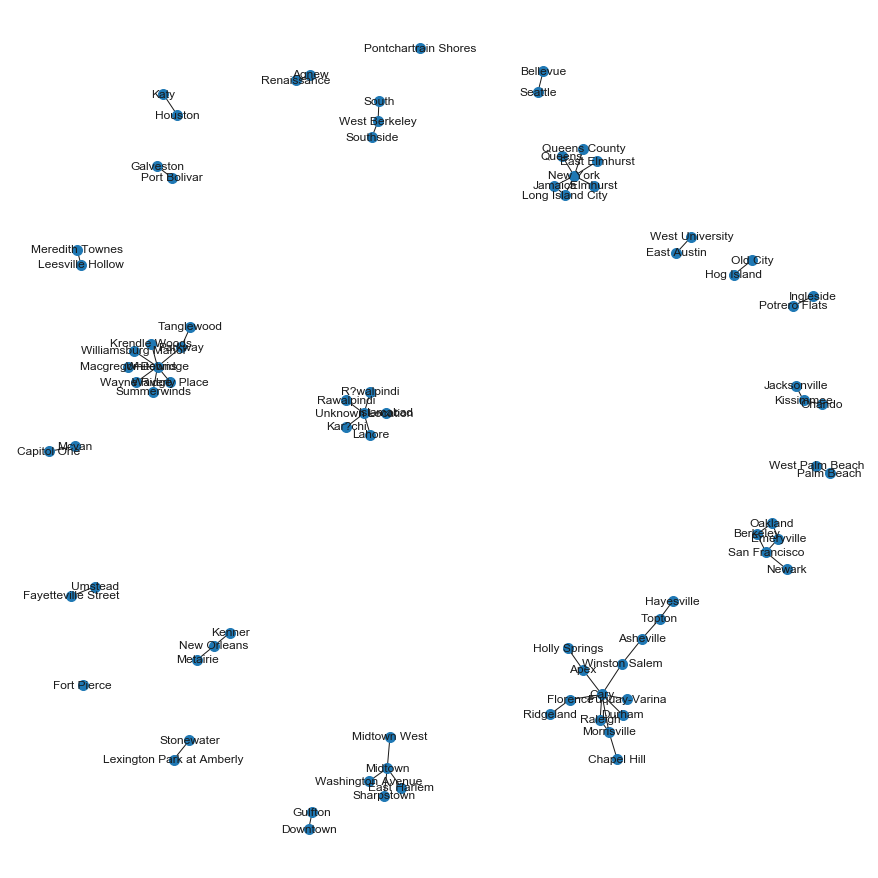

In [74]:
print (nx.info(g_meeting))
plt.figure(figsize=(12,12)) 
nx.draw_spring(g_meeting, with_labels=True, node_size=100)
plt.show()

In [68]:
degree_dict = dict(g_meeting.degree(g_meeting.nodes()))
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by degree:")

degree_dist = pd.DataFrame(sorted_degree, columns=['Location','Degree'])
degree_dist.sort_values(by='Degree',ascending=False).head(20).style.background_gradient(cmap=cmap)

Top 20 nodes by degree:


,Location,Degree
0,Cary,9
2,Unknown Location,7
1,Whitebridge,7
3,New York,6
4,Midtown,4
5,Kissimmee,4
10,Lahore,3
11,Kar?chi,3
9,San Francisco,3
8,R?walpindi,3


# Visalization of Network of Rides Based on Business Category Type

In [75]:
g_business = nx.Graph()
g_business = nx.from_pandas_edgelist(df[df['Category']=='Business'],source='Start',target='Stop')

Name: 
Type: Graph
Number of nodes: 200
Number of edges: 262
Average degree:   2.6200


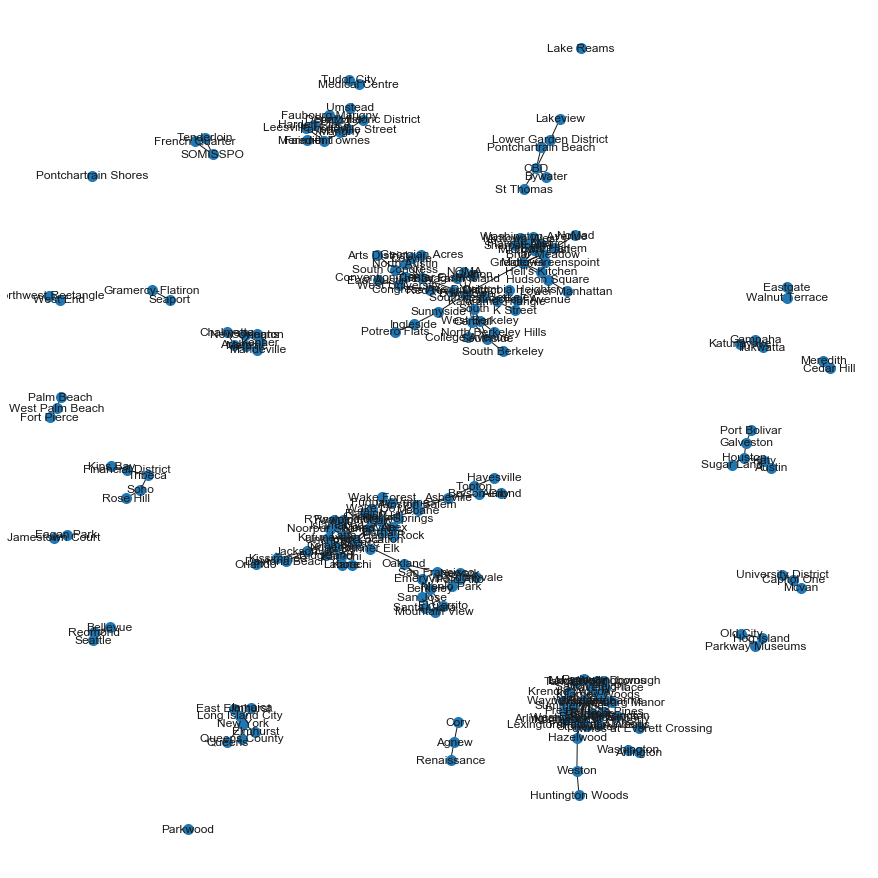

In [76]:
print (nx.info(g_business))
plt.figure(figsize=(12,12)) 
nx.draw_spring(g_business, with_labels=True, node_size=100)
plt.show()

In [77]:
degree_dict = dict(g_business.degree(g_business.nodes()))
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by degree:")

degree_dist = pd.DataFrame(sorted_degree, columns=['Location','Degree'])
degree_dist.sort_values(by='Degree',ascending=False).head(20).style.background_gradient(cmap=cmap)

Top 20 nodes by degree:


,Location,Degree
0,Whitebridge,26
1,Cary,17
2,Unknown Location,15
3,Midtown,14
4,Downtown,12
5,Morrisville,9
6,Berkeley,8
7,The Drag,7
8,Central,7
9,New York,6
